# 📚 AI를 활용한 생공용수 수요패턴 예측

## 1. 필요한 라이브러리 입력

In [1]:
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import os

from metrics import evaluate
from plots import bar_metrics

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="NanumGothic")
print(tf.__version__)

2022-09-22 01:48:42.836220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 01:48:43.024712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 01:48:43.024766: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-22 01:48:43.066507: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-22 01:48:44.131442: W tensorflow/stream_executor/platform/de

2.10.0


## 2. 데이터 불러오기 (예시: 서울특별시)

### 2.1 과거 영향인자 데이터 불러오기

 * 2001~2021년 월별 인구관련 영향인자 7개 ("총인구수", '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율')
               월별 기상관련 영향인자 3개 ("기온", "월강수량", "습도") 엑셀에서 불러오기

In [2]:
os.listdir('../data/영향분석/시군별_영향인자(독립변수)')

['전라북도',
 '충청남도',
 '시군구코드.xlsx',
 '충청북도',
 '경상북도',
 '특광역시',
 '제주도',
 '~$시군구코드.xlsx',
 '전라남도',
 '경기도',
 '강원도',
 '경상남도']

In [3]:
os.listdir('../data/영향분석/시군별_영향인자(독립변수)/특광역시')

['특별시 및 광역시 종합.xlsx']

In [4]:
factor_1 = pd.ExcelFile("../data/영향분석/시군별_영향인자(독립변수)/특광역시/특별시 및 광역시 종합.xlsx")
factor_1.sheet_names

['서울특별시', '세종특별자치시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시']

In [5]:
# 시군명 지정
CITY_NAME = '대전광역시'

In [6]:
factor_1 = pd.read_excel("../data/영향분석/시군별_영향인자(독립변수)/특광역시/특별시 및 광역시 종합.xlsx", sheet_name=CITY_NAME) # 시군별 영향인자 엑셀파일 읽기
factor_1_1 = factor_1.iloc[3:, :29] # header 및 일단위자료 삭제
factor_1_1.columns = factor_1.iloc[2, :29] # set column names
data_len = factor_1_1['연도'].isna().argmax()
factor_1_1 = factor_1_1[:data_len]
factor_1_1.index = pd.to_datetime(factor_1_1['연도'][:data_len].astype(str) + '-' + factor_1_1['월'][:data_len].astype(str))
factor_1_1.rename_axis(columns='', inplace=True)
factor_1_1.drop(columns=['연도', '월'], inplace=True)
# Simplify Column names
factor_1_1.columns = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', '전력사용량', '산업체 수', '100인 이상 사업장', 
                       '산업단지면적', '연간 가계소득', '연간 고등학교 졸업(명)', '연간 고등학교 졸업자 비율', '연간 인건비', '연간 평균 수입대비 인건비', '취업률(명)', 
                       '고용보험자 비율', '취약계층(개)', '취약계층(비율)', '기온', '월강수량', '습도', '일조량', '지중온도', '풍량', '기압']
# Change datatype from object to float
factor_1_1 = factor_1_1.astype(float)
# 해당 컬럼만 불러오기
factors = factor_1_1[["총인구수", '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', "기온", "월강수량", "습도"]]
factors = factors.astype(float)
factors.index.name = "date"
factors

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.2,61.2,68.0
2001-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,70.0,64.0
2001-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,16.0,54.0
2001-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.7,20.4,51.0
2001-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.5,30.2,60.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,1454679.0,659978.0,2.204133,725956.0,728723.0,0.996203,15.0,25.8,289.2,84.0
2021-09-01,1455058.0,661948.0,2.198145,726142.0,728916.0,0.996194,15.0,22.4,161.2,81.0
2021-10-01,1454228.0,662615.0,2.194680,725742.0,728486.0,0.996233,15.1,15.7,40.8,79.0


### 2.2 과거 종속변수 데이터 (용수공급량) 불러오기

 * 2001~2021년 월별 용수공급량 데이터 엑셀에서 불러오기

In [7]:
water_supply = pd.read_excel("../data/영향분석/시군별_용수공급량(종속변수).xlsx", sheet_name="종합(도별 정렬)", header=1)
water_supply.set_index("지자체명", inplace=True)
water_supply = water_supply.iloc[1:, ]
water_supply = water_supply[[CITY_NAME]]
water_supply.rename(columns = {CITY_NAME:f'{CITY_NAME}'}, inplace = True)
water_supply = water_supply.astype(float)
water_supply.index = pd.to_datetime(water_supply.index.astype(str))
water_supply.index.name = "date"
water_supply

,대전광역시
date,
1991-01-01,155145.0
1991-02-01,115452.0
1991-03-01,81113.0
1991-04-01,121198.0
1991-05-01,177419.0
...,...
2021-08-01,19742588.0
2021-09-01,18272102.0
2021-10-01,17609898.0


### 2.3 미래 영향인자 불러오기

 * 2022~2037년 년별 "총인구수", '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율' 자료

In [8]:
future_factor = pd.read_excel("../data/수요예측/시군별_영향인자_장래예측/특광역시.xlsx", sheet_name=CITY_NAME)
future_factor_1 = future_factor.iloc[3:19, :8] # header 및 일단위자료 삭제
future_factor_1.columns = future_factor.iloc[2, :8] # set column names
future_factor_1.index = pd.to_datetime(future_factor_1["연도"], format='%Y')
future_factor_1 = future_factor_1.resample('MS').ffill()
future_factor_1.index.name = "date"
future_factors1 = future_factor_1[future_factor_1.columns[1:]]
future_factors1.columns = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율']
future_factors1 = future_factors1.astype(float)
future_factors1

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율
date,,,,,,,
2022-01-01,1482642.0,617304.0,2.401802,743267.0,739375.0,1.005264,0.154391
2022-02-01,1482642.0,617304.0,2.401802,743267.0,739375.0,1.005264,0.154391
2022-03-01,1482642.0,617304.0,2.401802,743267.0,739375.0,1.005264,0.154391
2022-04-01,1482642.0,617304.0,2.401802,743267.0,739375.0,1.005264,0.154391
2022-05-01,1482642.0,617304.0,2.401802,743267.0,739375.0,1.005264,0.154391
...,...,...,...,...,...,...,...
2036-09-01,1410063.0,638600.0,2.208054,701707.0,708356.0,0.990613,0.286791
2036-10-01,1410063.0,638600.0,2.208054,701707.0,708356.0,0.990613,0.286791
2036-11-01,1410063.0,638600.0,2.208054,701707.0,708356.0,0.990613,0.286791


### 2.4 미래 기후 영향인자 불러오기

 * 2022~2040년 년별 "월강수량", "습도", "최고온도", "최저온도", "평균온도"

In [9]:
future_factor_3 = future_factor.iloc[3:, 22:28] # header 및 일단위자료 삭제
future_factor_3.columns = future_factor.iloc[2, 22:28] # set column names
future_factor_3.index = pd.to_datetime(future_factor_3["날짜"], format='%Y%M%D')
future_factor_3.index.name = "date"
future_factors2 = future_factor_3[['월합강수량(mm)', '습도\n평균상대습도(%)', '평균온도(°C)']]
future_factors2.columns = ['월강수량', '습도', '기온']
future_factors2 = future_factors2.astype(float)
future_factors2

,월강수량,습도,기온
date,,,
2011-01-01,2.596929,0.628220,0.477549
2011-02-01,63.125113,0.662087,5.502749
2011-03-01,79.397892,0.604610,7.466347
2011-04-01,50.485890,0.551588,13.832135
2011-05-01,48.939082,0.610604,18.381350
...,...,...,...
2040-08-01,161.662596,0.787454,29.404257
2040-09-01,135.332490,0.781525,24.246118
2040-10-01,9.375957,0.668401,17.919819


### 2.5 용수수요 추정을 위한 과거 및 미래자료 합치기


In [10]:
total_data = pd.merge(water_supply, factors, on="date", how="left")
future_factors1_1 = future_factors1.loc["2022-01-01":"2035-01-01"]
future_factors2_1 = future_factors2.loc["2022-01-01":"2035-01-01"]
future_factor = pd.concat([future_factors1_1, future_factors2_1], axis=1)
total_data_df = pd.concat([total_data, future_factor], axis=0)
total_data_df

,대전광역시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
1991-01-01,155145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-01,115452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-01,81113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-01,121198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-01,177419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2034-09-01,NaN,1420205.0,637962.0,2.226159,707643.0,712562.0,0.993097,0.268028,23.358469,43.971995,0.756104
2034-10-01,NaN,1420205.0,637962.0,2.226159,707643.0,712562.0,0.993097,0.268028,16.438299,11.523479,0.667603
2034-11-01,NaN,1420205.0,637962.0,2.226159,707643.0,712562.0,0.993097,0.268028,11.106472,13.705435,0.665412


### 2.6 이용가능한 데이터 기간 검토


 - 물공급량: 1991-01월 ~ 2021-12월
 - 지역성 영향인자: 2008-01월 ~ 2034-12월
 - 계절성 영향인자: 2001-01월 ~ 2034-12월  

<div class="alert alert-block alert-info">
    
<b> 지역성 영향인자와 계절성 영향인자의 이용가능한 데이터 기간을 고려한 용수수요 AI모델개발을 위한 데이터 현황
    
<b>   - 데이터 이용가능 기간: 2008-01월~2021년12월 (총 168개 데이터, 14년) <b>
    
<b>   - Training       기간: 2008-01월~2018년12월 (총 132개 데이터, 11년)  <b>
    
<b>   - Testing        기간: 2019-01월~2021년12월 (총  36개 데이터,  3년) </b> </div>

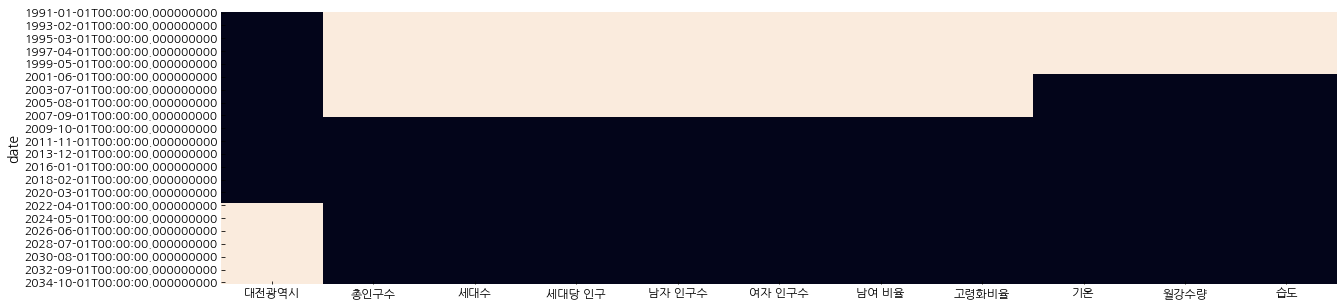

In [11]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(total_data_df.isnull(), cbar=False)
plt.show()

## 3. 시계열 자료 분석

### 3.1 시계열자료 불러오기 및 Review


In [12]:
total_data_df_ts_analysis = total_data_df.loc["2008-01-01":"2021-12-01"]
total_data_df_ts_analysis

,대전광역시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
2008-01-01,16163374.0,1476476.0,526393.0,2.804893,739943.0,736533.0,1.004630,7.8,-0.9,45.3,61.0
2008-02-01,15291750.0,1477556.0,527121.0,2.803068,740471.0,737085.0,1.004594,7.8,-0.8,9.1,49.0
2008-03-01,16273438.0,1476338.0,526884.0,2.802017,739542.0,736796.0,1.003727,7.9,7.6,29.1,54.0
2008-04-01,15703929.0,1477032.0,527496.0,2.800082,739831.0,737201.0,1.003568,7.9,14.0,34.4,53.0
2008-05-01,16399856.0,1477420.0,527917.0,2.798584,740031.0,737389.0,1.003583,7.9,18.1,59.2,57.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,19742588.0,1454679.0,659978.0,2.204133,725956.0,728723.0,0.996203,15.0,25.8,289.2,84.0
2021-09-01,18272102.0,1455058.0,661948.0,2.198145,726142.0,728916.0,0.996194,15.0,22.4,161.2,81.0
2021-10-01,17609898.0,1454228.0,662615.0,2.194680,725742.0,728486.0,0.996233,15.1,15.7,40.8,79.0


In [13]:
total_data_df_ts_analysis.describe().applymap('{:,.2f}'.format)

,대전광역시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
count,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00,168.00
mean,"17,088,087.23","1,500,324.39","591,256.45",2.55,"750,557.67","749,766.71",1.00,10.74,13.35,104.56,68.55
std,"1,123,622.29","23,596.09","38,968.13",0.18,"12,327.15","11,327.04",0.00,2.14,9.72,111.63,9.14
min,"12,710,398.00","1,452,251.00","526,393.00",2.19,"724,626.00","727,625.00",1.00,7.80,-5.70,1.70,49.00
25%,"16,345,117.75","1,481,515.00","561,298.00",2.41,"741,584.25","739,901.75",1.00,8.80,4.38,33.65,61.00
50%,"17,088,536.50","1,503,613.50","592,778.50",2.58,"752,902.00","750,734.50",1.00,10.35,14.25,62.80,69.00
75%,"17,694,724.00","1,521,271.25","619,490.25",2.69,"761,460.00","759,511.75",1.00,12.40,22.40,133.97,76.00
max,"19,745,280.00","1,536,349.00","664,417.00",2.80,"768,832.00","767,517.00",1.01,15.20,29.00,587.30,88.00


Lets check each feature values

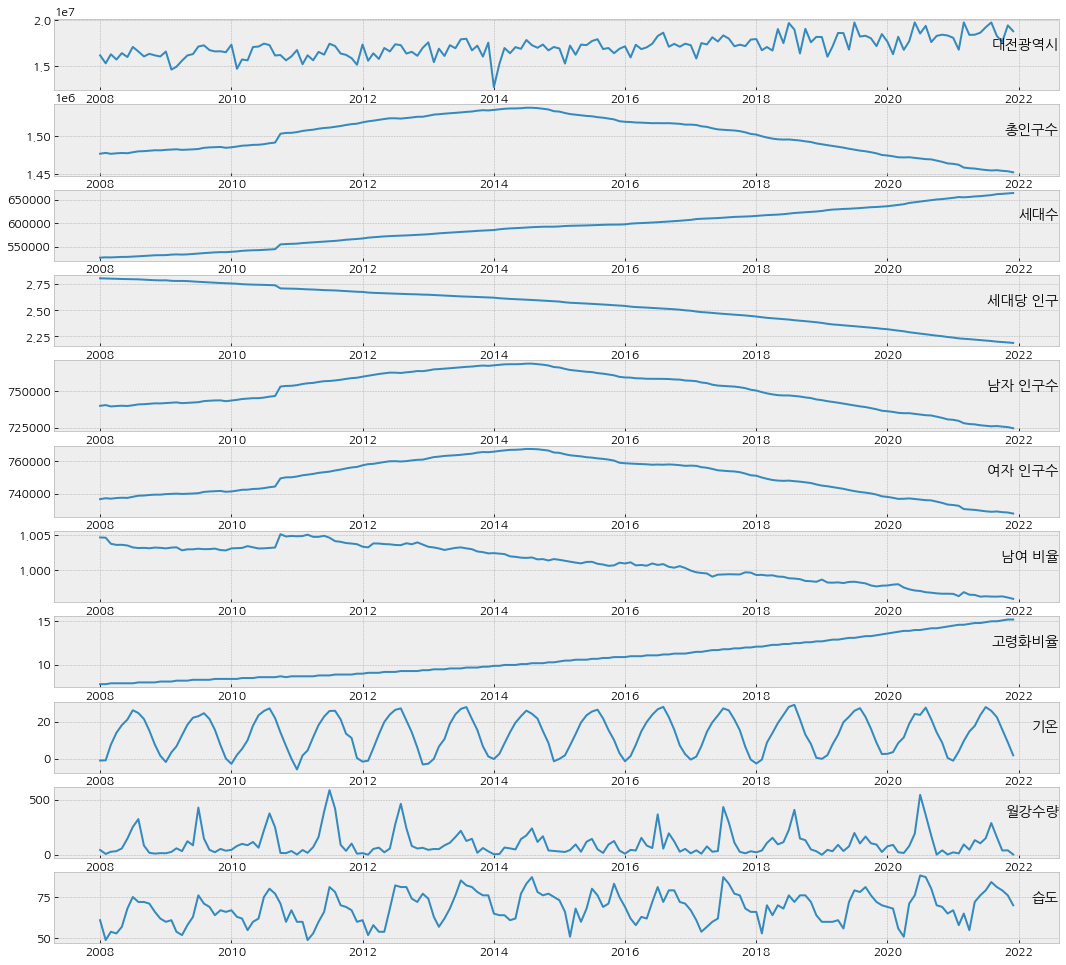

In [14]:
rcParams['figure.figsize'] = 18, 17
values = total_data_df_ts_analysis.values
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(total_data_df_ts_analysis.index,  values[:, group])
    plt.title(total_data_df_ts_analysis.columns[group], y=0.5, loc='right')
    i += 1

plt.show()

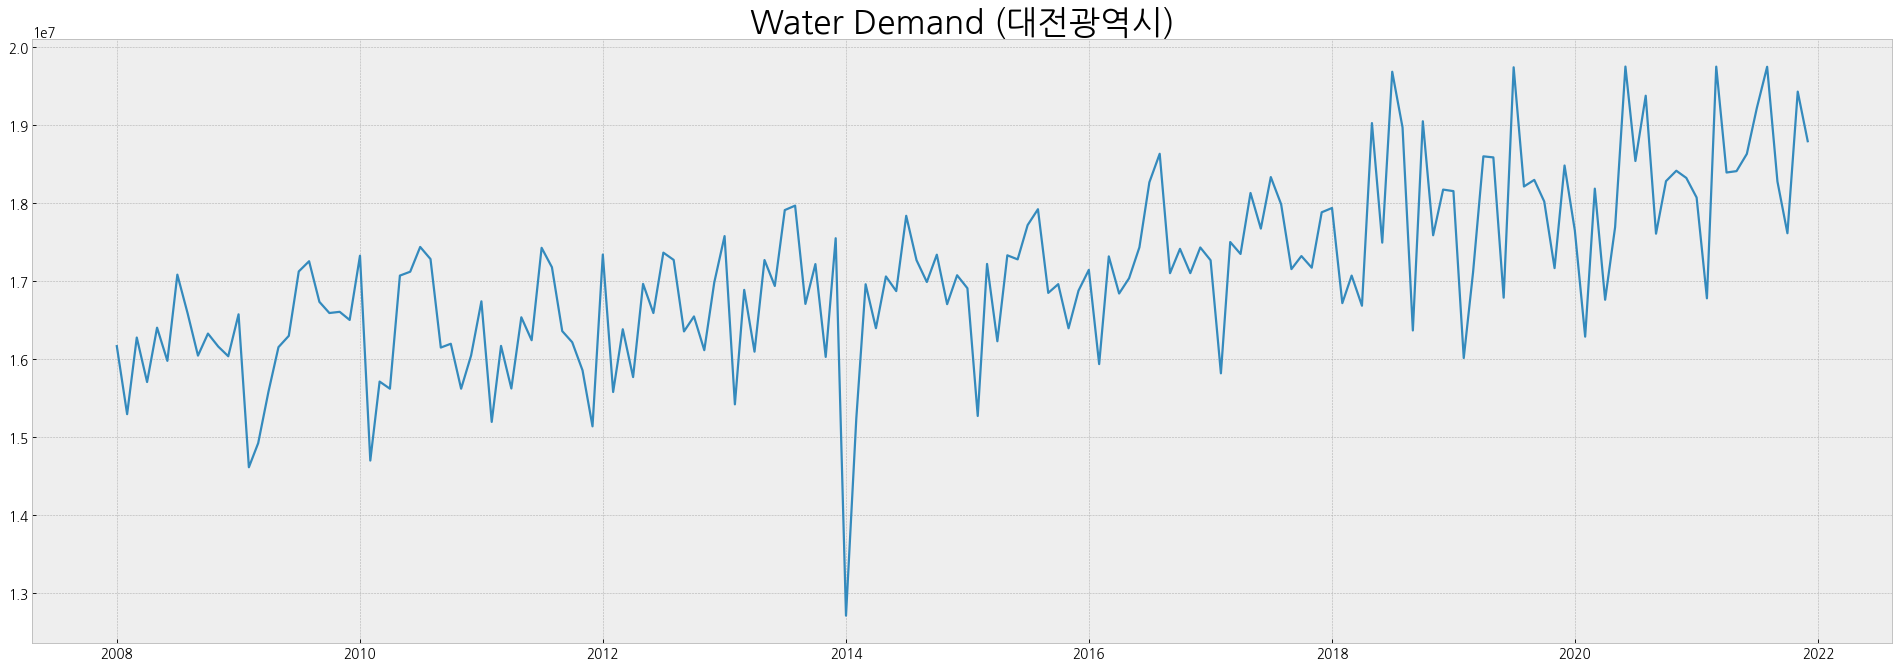

In [15]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Water Demand (%s)'%CITY_NAME, fontsize=30)

plt.plot(total_data_df_ts_analysis[CITY_NAME])
os.makedirs("results", exist_ok=True)
plt.savefig("results/water_demand.png")

### 3.2 시계열자료 분해


시계열 자료를 추세(Trend), 계절성(Seasonality)와 잔여분(Resid, Residual)을 활용하여 시계열 자료 특성 분석

##### Additive Model (덧셈모델)
`y(t) = Value + Trend + Seasonality + Noise`

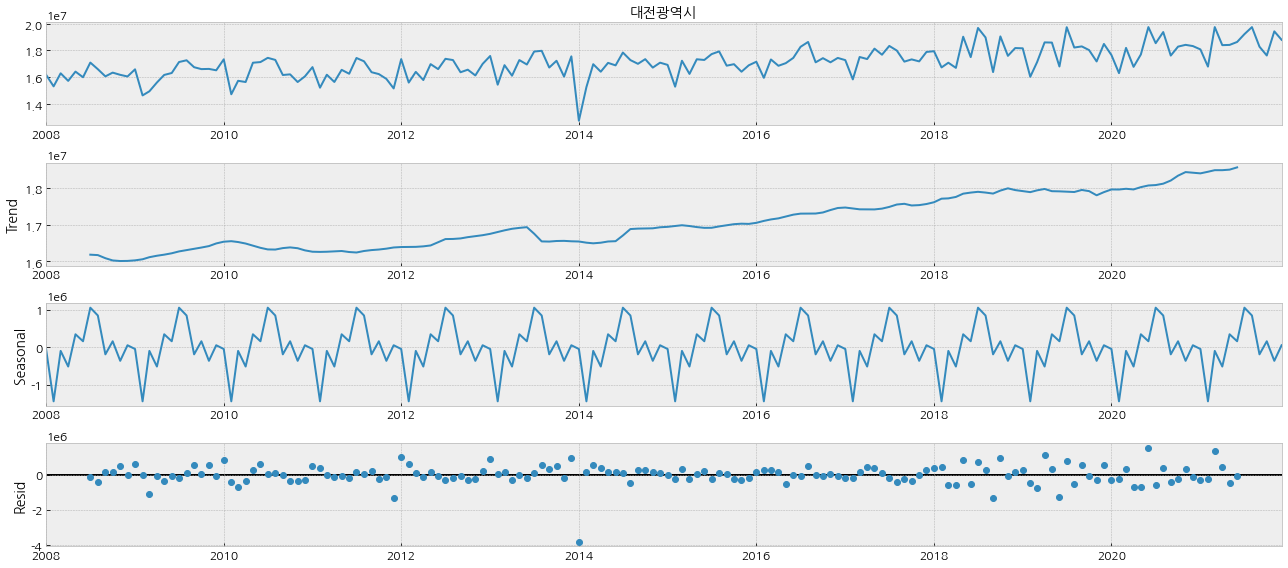

<Figure size 4000x1600 with 0 Axes>

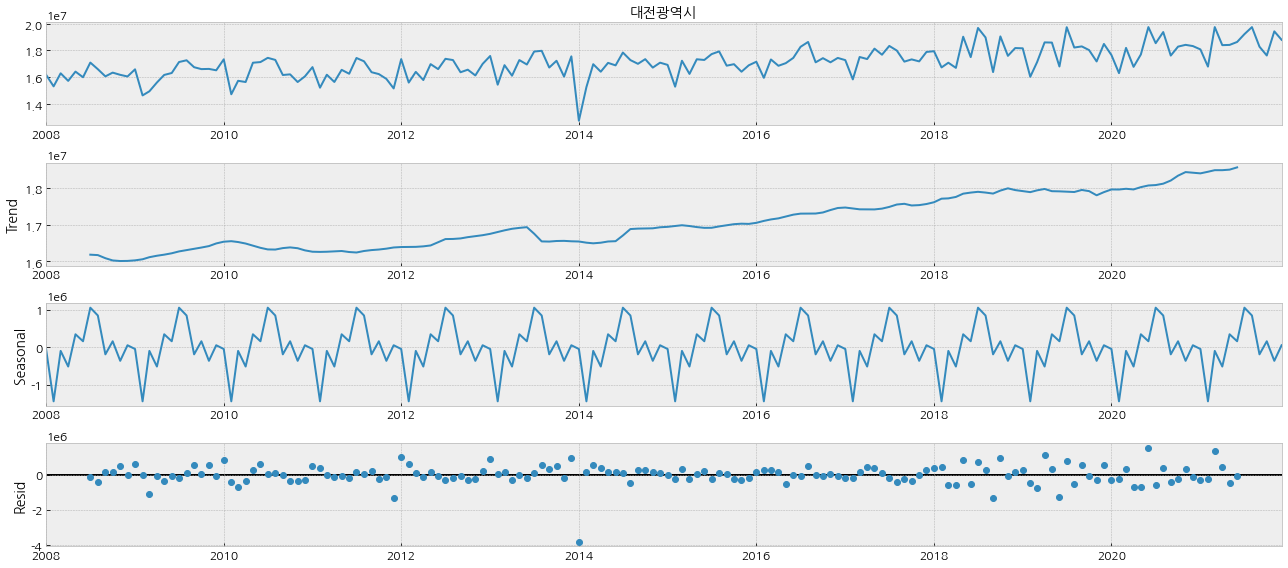

In [16]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = total_data_df_ts_analysis[CITY_NAME][:168]
result = seasonal_decompose(series, model='additive')
result.plot()

##### Multiplicative model (곱셈모델)
`y(t) = Level * Trend * Seasonality * Noise`

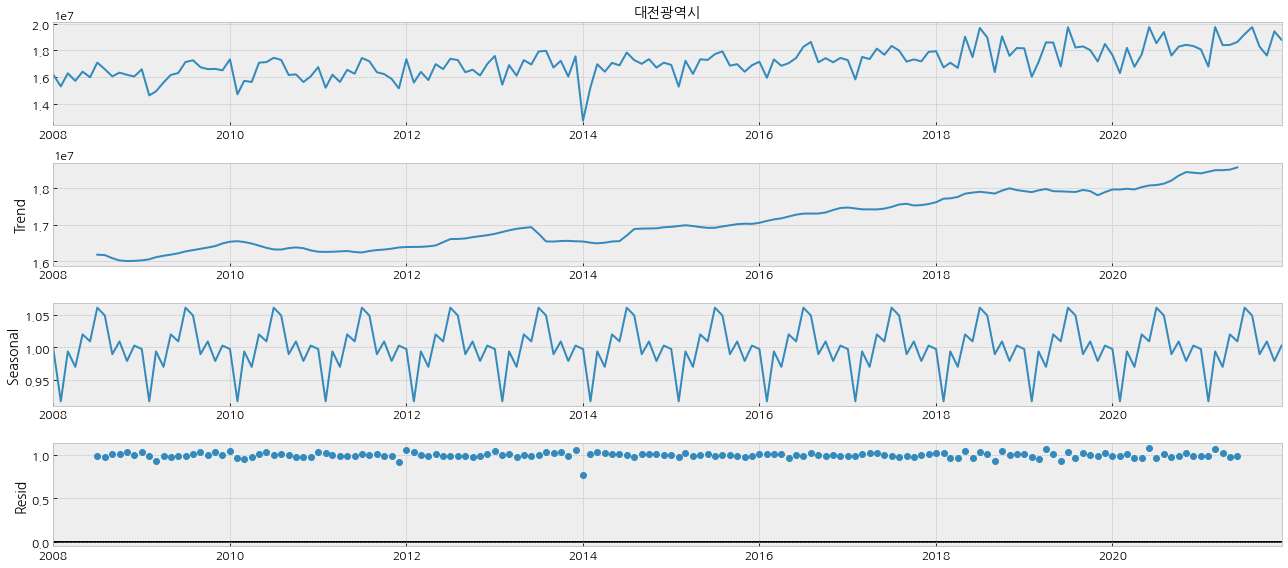

<Figure size 4000x1600 with 0 Axes>

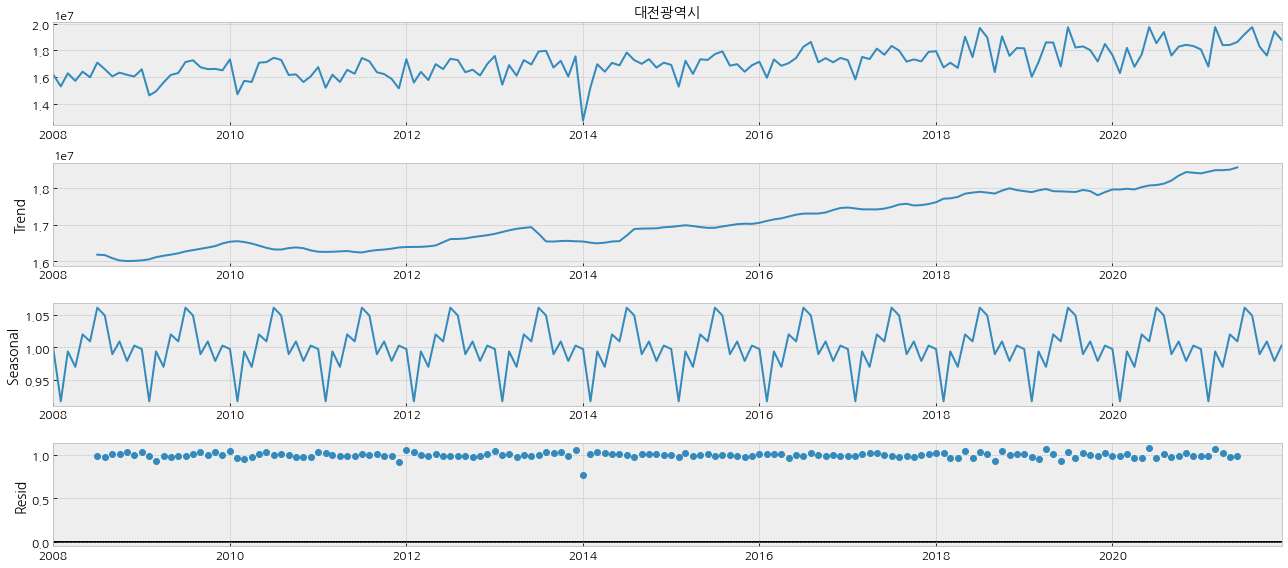

In [17]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = total_data_df_ts_analysis[CITY_NAME][:168]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

### 3.3 시계열 데이터의 정상성 확인

#### AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF) plots

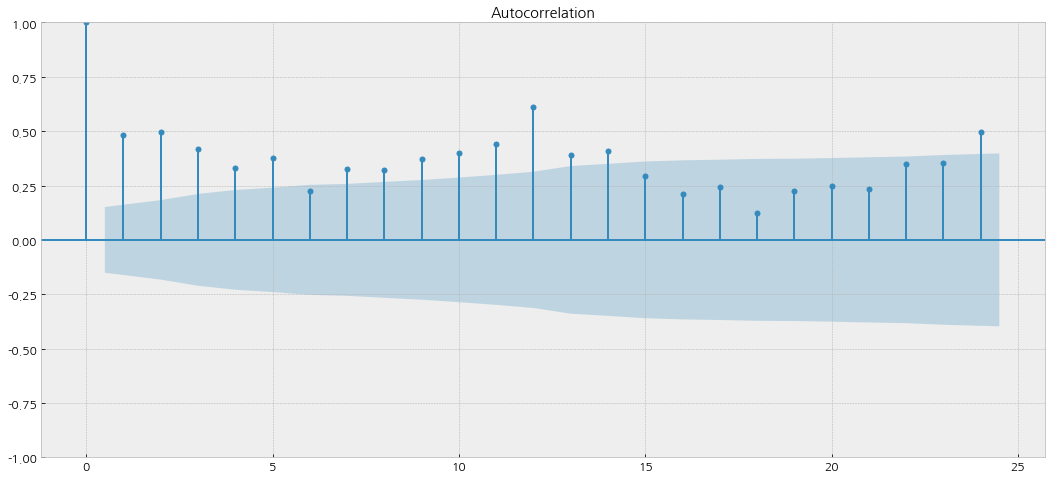

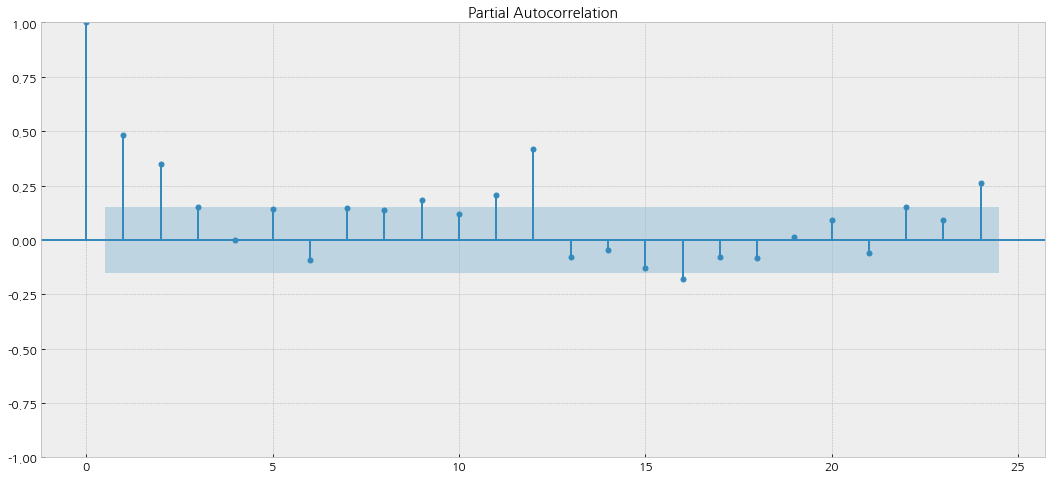

In [18]:
plot_acf(series, lags=24)
plot_pacf(series, lags=24)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

### Augmented Dickey-Fuller test


In [19]:
X = total_data_df_ts_analysis[CITY_NAME][:168].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.506978
p-value: 0.985084
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


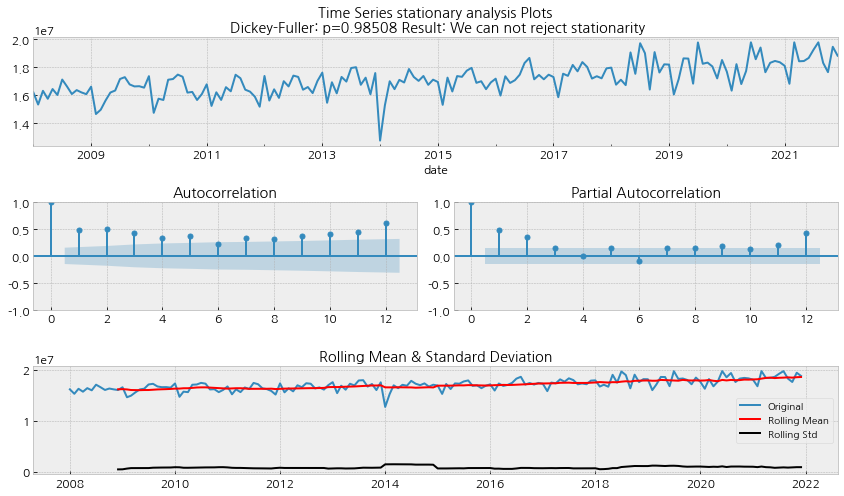

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = total_data_df_ts_analysis[CITY_NAME][:168].rolling(window=12).mean()
        rolstd = total_data_df_ts_analysis[CITY_NAME][:168].rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(total_data_df_ts_analysis[CITY_NAME][:168], label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(total_data_df_ts_analysis[CITY_NAME][:168], lags=12)

## 4. 용수수요 추정

### 4.1 데이터 준비

In [21]:
total_data_df_ts_analysis = total_data_df.loc["2008-01-01":"2021-12-01"]
total_data_df_ts_analysis.head()

,대전광역시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
2008-01-01,16163374.0,1476476.0,526393.0,2.804893,739943.0,736533.0,1.004630,7.8,-0.9,45.3,61.0
2008-02-01,15291750.0,1477556.0,527121.0,2.803068,740471.0,737085.0,1.004594,7.8,-0.8,9.1,49.0
2008-03-01,16273438.0,1476338.0,526884.0,2.802017,739542.0,736796.0,1.003727,7.9,7.6,29.1,54.0
2008-04-01,15703929.0,1477032.0,527496.0,2.800082,739831.0,737201.0,1.003568,7.9,14.0,34.4,53.0
2008-05-01,16399856.0,1477420.0,527917.0,2.798584,740031.0,737389.0,1.003583,7.9,18.1,59.2,57.0


#### Training과 Testing 데이터의 구분

In [22]:
# We split our dataset to be able to evaluate our models
resultsDict = {}
predictionsDict = {}

split_date = '2019-12-01'
df_training = total_data_df_ts_analysis[:168].loc[total_data_df_ts_analysis[:168].index <= split_date]
df_test = total_data_df_ts_analysis[:168].loc[total_data_df_ts_analysis[:168].index > split_date]
print(f"{len(df_training)} months of training data \n {len(df_test)} months of testing data ")

144 months of training data 
 24 months of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

### 4.2 Autoregressive integrated moving average (ARIMA)

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test[CITY_NAME]))):
    temp_train = total_data_df_ts_analysis[:len(df_training)+t]
    model = ARIMA(temp_train[CITY_NAME], order=(3, 2, 2))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test[CITY_NAME], yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


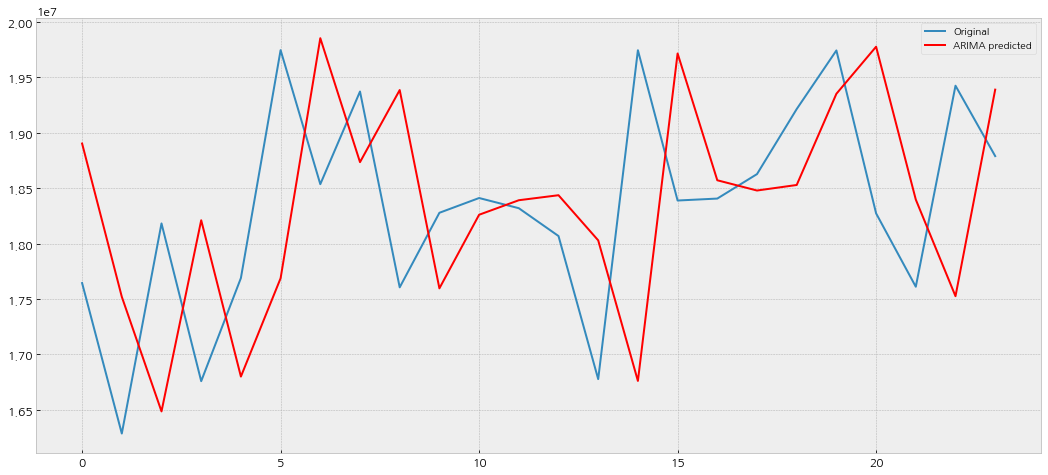

In [25]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [26]:
resultsDict['ARIMA']

{'mae': 1055987.297015898,
 'rmse': 1271940.9901568769,
 'mape': 0.057657087780115,
 'r2': -0.8927389824014909}

### 4.3 Auto ARIMA

In [27]:
# building the model
autoModel = pm.auto_arima(df_training[CITY_NAME], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training[CITY_NAME])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4391.523, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4371.882, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4373.272, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4389.557, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4375.064, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4374.813, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4376.671, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4370.142, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4373.331, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4373.099, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4371.706, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4375.106, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.174 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [28]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test[CITY_NAME]))):
    temp_train = total_data_df_ts_analysis[:len(df_training)+t]
    model = ARIMA(temp_train[CITY_NAME], order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test[CITY_NAME], yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 24/24 [00:01<00:00, 23.75it/s]


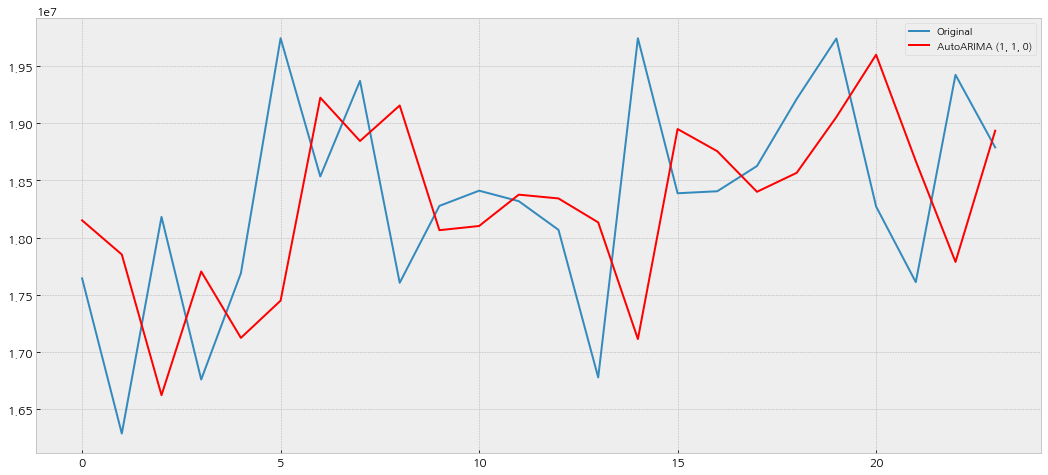

In [29]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

In [30]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412}}

### 4.4 Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [31]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test[CITY_NAME]))):
    temp_train = total_data_df_ts_analysis[:len(df_training)+t]
    model = SARIMAX(temp_train[CITY_NAME], order=(
        3, 2, 2), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test[CITY_NAME], yhat.values)
predictionsDict['SARIMAX'] = yhat.values

 29%|██▉       | 7/24 [00:06<00:13,  1.22it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56397D+01    |proj g|=  6.94632D-01

At iterate    5    f=  1.53868D+01    |proj g|=  1.05211D-02

At iterate   10    f=  1.53812D+01    |proj g|=  9.63260D-03

At iterate   15    f=  1.53706D+01    |proj g|=  3.50516D-02

At iterate   20    f=  1.53642D+01    |proj g|=  9.12163D-03

At iterate   25    f=  1.53628D+01    |proj g|=  6.93153D-03

At iterate   30    f=  1.53623D+01    |proj g|=  2.89591D-03

At iterate   35    f=  1.53621D+01    |proj g|=  5.56472D-03

At iterate   40    f=  1.53620D+01    |proj g|=  3.94592D-03

At iterate   45    f=  1.53619D+01    |proj g|=  1.66762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 58%|█████▊    | 14/24 [00:11<00:07,  1.39it/s]

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     43      1     0     0   2.122D-05   1.539D+01
  F =   15.388879686250512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56142D+01    |proj g|=  5.91678D-01

At iterate    5    f=  1.53968D+01    |proj g|=  3.68964D-02

At iterate   10    f=  1.53948D+01    |proj g|=  3.53025D-02

At iterate   15    f=  1.53938D+01    |proj g|=  1.99002D-03

At iterate   20    f=  1.5

 88%|████████▊ | 21/24 [00:15<00:01,  1.51it/s]

Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     34      1     0     0   6.682D-06   1.539D+01
  F =   15.385389265995602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55914D+01    |proj g|=  5.56161D-01

At iterate    5    f=  1.53896D+01    |proj g|=  2.19267D-02

At iterate   10    f=  1.53883D+01    |proj g|=  1.84869D-02

At iterate   15    f=  1.53875D+01    |proj g|=  1.28330D-02

At iterate   20    f=  1.53867D+01    |proj g|=  4.25673D-03

At iterate   25    f=  1.53864D+01    |proj g|=  3.44233D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function 

100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


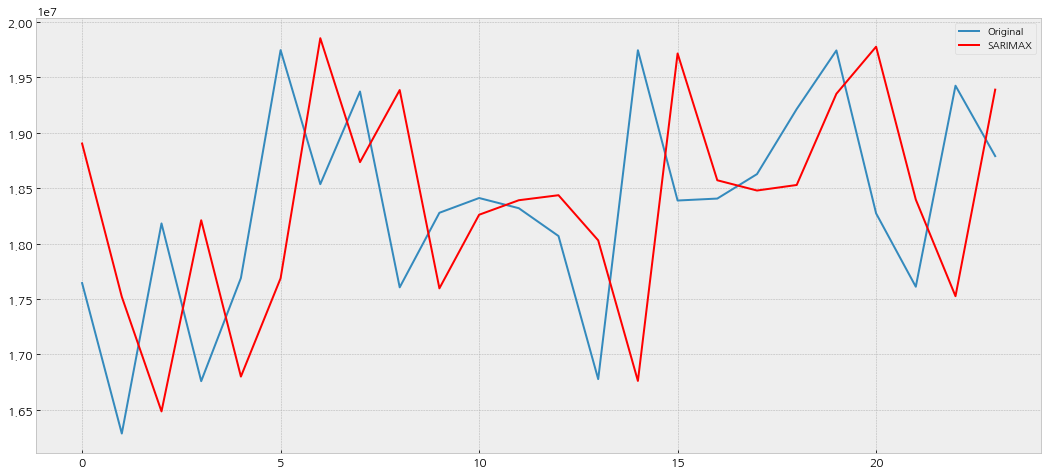

In [32]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [33]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909}}

### 4.5 Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [34]:
# building the model
autoModel = pm.auto_arima(df_training[CITY_NAME], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training[CITY_NAME])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=12.50 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=4391.523, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=4373.455, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=4374.787, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=4389.557, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=4371.882, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=4373.555, Time=0.95 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=4363.692, Time=1.51 sec
 ARIMA(1,1,0)(2,0,1)[6] intercept   : AIC=4360.742, Time=4.59 sec
 ARIMA(1,1,0)(2,0,0)[6] intercept   : AIC=4363.856, Time=1.60 sec
 ARIMA(1,1,0)(2,0,2)[6] intercept   : AIC=4359.050, Time=8.00 sec
 ARIMA(1,1,0)(1,0,2)[6] intercept   : AIC=4361.184, Time=4.71 sec
 ARIMA(0,1,0)(2,0,2)[6] intercept   : AIC=4375.626, Time=4.19 sec
 ARIMA(2,1,0)(2,0,2)[6] intercept   : AIC=4361.400, Time=7.11 sec
 ARIMA(1,1,1)(2,0,2)[6] intercept   :

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 0, 2, 6),
      suppress_warnings=True)

In [35]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test[CITY_NAME]))):
    temp_train = total_data_df_ts_analysis[:len(df_training)+t]
    model = SARIMAX(temp_train[CITY_NAME], order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test[CITY_NAME], yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

 12%|█▎        | 3/24 [00:25<02:49,  8.09s/it]

    6     31     34      1     0     0   7.008D-06   1.539D+01
  F =   15.391806078470974     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55827D+01    |proj g|=  5.57072D-01

At iterate    5    f=  1.53993D+01    |proj g|=  3.15299D-02

At iterate   10    f=  1.53957D+01    |proj g|=  2.40026D-02

At iterate   15    f=  1.53950D+01    |proj g|=  9.50080D-03

At iterate   20    f=  1.53924D+01    |proj g|=  9.35768D-03

At iterate   25    f=  1.53924D+01    |proj g|=  1.36245D-04

At iterate   30    f=  1.53924D+01    |proj g|=  4.17621D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fina

 46%|████▌     | 11/24 [01:22<01:30,  6.97s/it]

    6     28     33      1     0     0   2.717D-05   1.508D+01
  F =   15.084129792151169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52730D+01    |proj g|=  5.54699D-01

At iterate    5    f=  1.50972D+01    |proj g|=  3.15183D-02

At iterate   10    f=  1.50916D+01    |proj g|=  6.41731D-03

At iterate   15    f=  1.50896D+01    |proj g|=  4.56656D-02

At iterate   20    f=  1.50862D+01    |proj g|=  1.73344D-02

At iterate   25    f=  1.50859D+01    |proj g|=  1.67698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected

 75%|███████▌  | 18/24 [02:09<00:40,  6.79s/it]

At iterate    0    f=  1.52801D+01    |proj g|=  5.13556D-01

At iterate    5    f=  1.51200D+01    |proj g|=  6.36493D-02

At iterate   10    f=  1.51104D+01    |proj g|=  8.40293D-03

At iterate   15    f=  1.51075D+01    |proj g|=  2.65697D-02

At iterate   20    f=  1.51056D+01    |proj g|=  2.80888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   6.926D-05   1.511D+01
  F =   15.105634566948307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


100%|██████████| 24/24 [02:54<00:00,  7.29s/it]


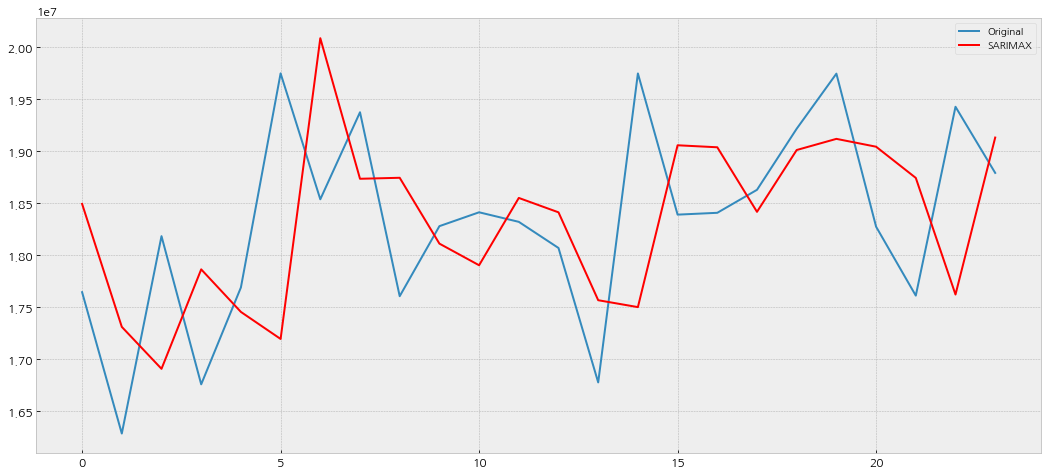

In [36]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [37]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958}}

### 4.6 Prophet

Prophet is a model released by [facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.


In [38]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={CITY_NAME: 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={CITY_NAME: 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [39]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
)

In [40]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test[CITY_NAME], yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

01:54:15 - cmdstanpy - INFO - Chain [1] start processing
01:54:15 - cmdstanpy - INFO - Chain [1] done processing


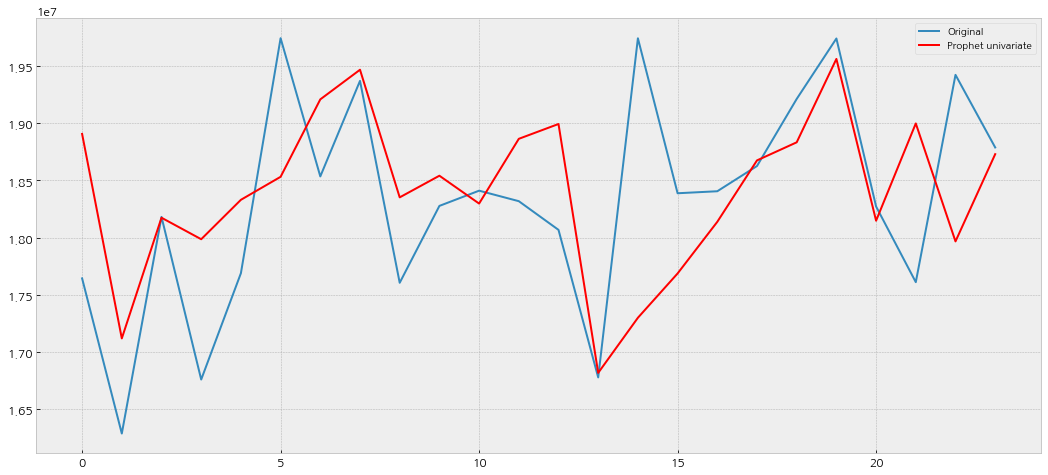

In [41]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

In [42]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785}}

### 4.7 Random Forest

In [43]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [44]:
X_train_df, y_train = create_time_features(
    df_training, target=CITY_NAME)
X_test_df, y_test = create_time_features(df_test, target=CITY_NAME)
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [45]:
reg = RandomForestRegressor(random_state=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test[CITY_NAME], yhat)
predictionsDict['Randomforest'] = yhat

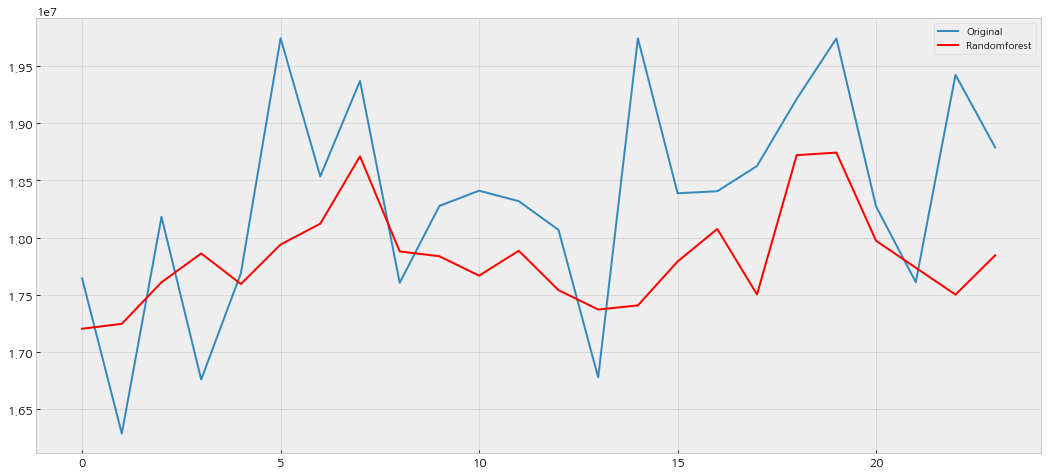

In [46]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='Randomforest')
plt.legend()

In [47]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785},
 'Randomforest': {'mae': 760071.7591666671,
  'rmse': 942424.9559724096,
  'mape': 0.04088445211782288,
  'r2': -0.03908327890409269}}

### 4.8 XGBoost

In [48]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test[CITY_NAME], yhat)
predictionsDict['XGBoost'] = yhat

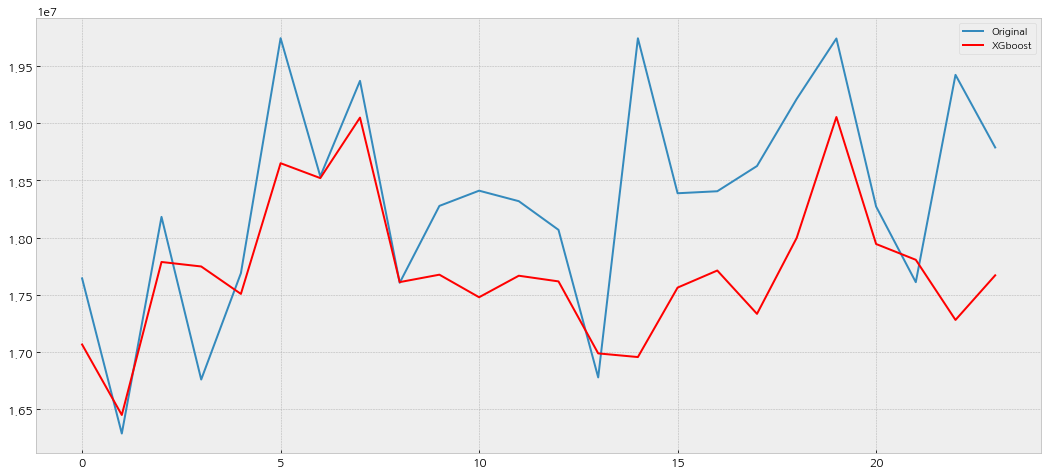

In [49]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [50]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785},
 'Randomforest': {'mae': 760071.7591666671,
  'rmse': 942424.9559724096,
  'mape': 0.04088445211782288,
  'r2': -0.03908327890409269},
 'XGBoost': {'mae': 745320.4583333334,
  'rmse': 985533.2063473517,
  'mape': 0.039760744961155,
  'r2': -0.13631652887291779}}

### 4.9 Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM)

In [51]:
X_train

array([[-1.55928373, -1.70345456,  1.495227  , ..., -0.79293943,
        -1.59325501, -1.59325501],
       [-1.50317849, -1.68080196,  1.48192406, ..., -2.13627211,
        -1.30357228, -1.59325501],
       [-1.56645274, -1.6881765 ,  1.47426389, ..., -1.57655016,
        -1.01388955, -1.59325501],
       ...,
       [-1.45746311,  1.64897483, -1.95607998, ...,  0.88622642,
         1.01388955,  1.59325501],
       [-1.53440002,  1.6636928 , -1.98575903, ...,  0.43844886,
         1.30357228,  1.59325501],
       [-1.6427143 ,  1.68665656, -2.02938765, ...,  0.21456008,
         1.59325501,  1.59325501]])

In [52]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test[CITY_NAME], yhat)
predictionsDict['Lightgbm'] = yhat

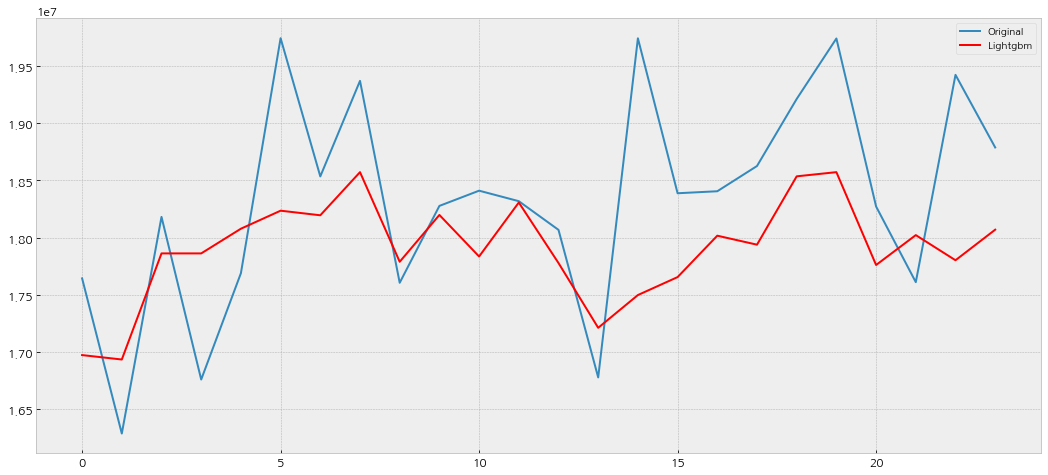

In [53]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm')
plt.legend()

In [54]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785},
 'Randomforest': {'mae': 760071.7591666671,
  'rmse': 942424.9559724096,
  'mape': 0.04088445211782288,
  'r2': -0.03908327890409269},
 'XGBoost': {'mae': 745320.4583333334,
  'rmse': 985533.2063473517,
  'mape': 0.039760744961155,
  'r2': -0.13631652887291779},
 'Lightgbm': {'mae': 688704.5463087913,
  'rmse':

### 4.10 Prophet multivariate

In [55]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    #daily_seasonality=True,
)#.add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [56]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

01:54:18 - cmdstanpy - INFO - Chain [1] start processing
01:54:18 - cmdstanpy - INFO - Chain [1] done processing


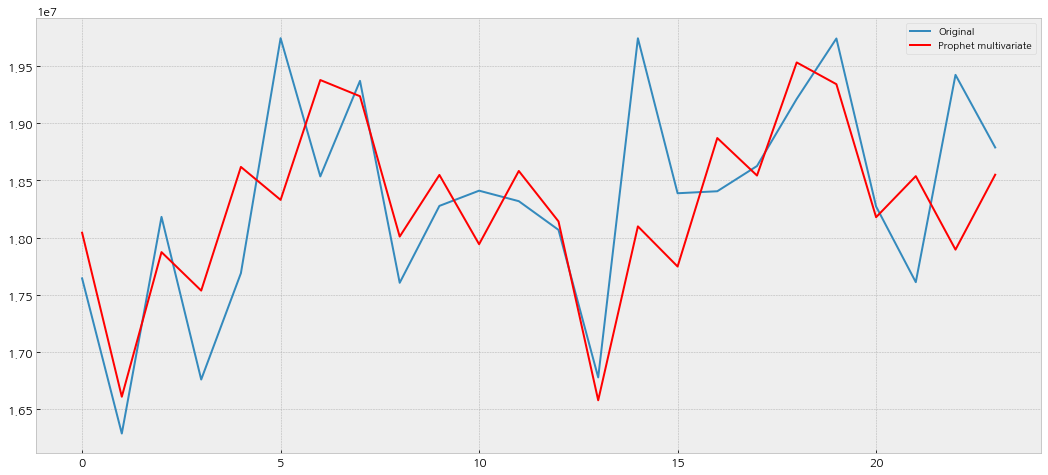

In [57]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

In [58]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785},
 'Randomforest': {'mae': 760071.7591666671,
  'rmse': 942424.9559724096,
  'mape': 0.04088445211782288,
  'r2': -0.03908327890409269},
 'XGBoost': {'mae': 745320.4583333334,
  'rmse': 985533.2063473517,
  'mape': 0.039760744961155,
  'r2': -0.13631652887291779},
 'Lightgbm': {'mae': 688704.5463087913,
  'rmse':

### 4.11 DeepAR

[DeepAR](https://arxiv.org/pdf/1704.04110.pdf) is a deep learning architecture released by amazon

In [59]:
features = df_training.columns[1:11]

scaler = StandardScaler()
scaler.fit(X_train[:,:10])  # No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training[CITY_NAME],
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test[CITY_NAME],
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [60]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)


100%|██████████| 50/50 [00:13<00:00,  3.84it/s, epoch=5/5, avg_epoch_loss=15]


In [61]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat

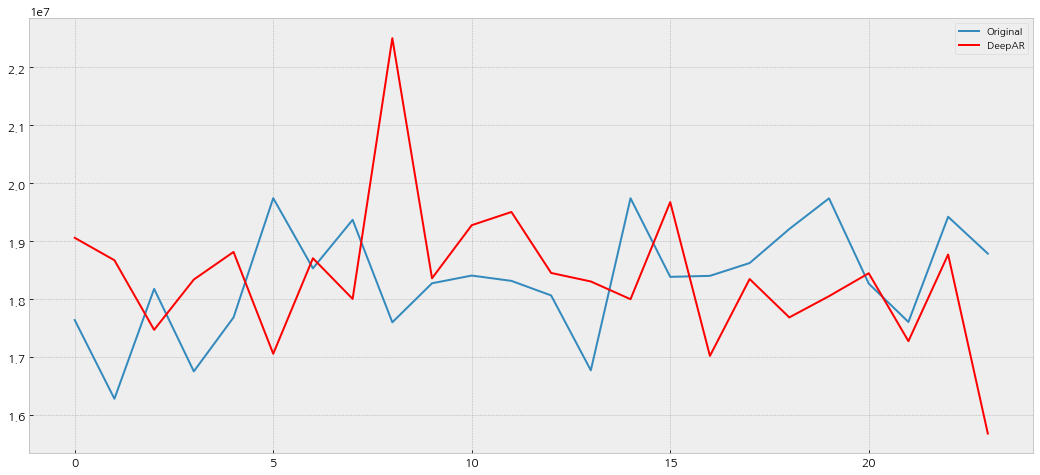

In [62]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='DeepAR')
plt.legend()

In [63]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785},
 'Randomforest': {'mae': 760071.7591666671,
  'rmse': 942424.9559724096,
  'mape': 0.04088445211782288,
  'r2': -0.03908327890409269},
 'XGBoost': {'mae': 745320.4583333334,
  'rmse': 985533.2063473517,
  'mape': 0.039760744961155,
  'r2': -0.13631652887291779},
 'Lightgbm': {'mae': 688704.5463087913,
  'rmse':

### 4.12 Bayesian processes - Xgboost

In [64]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    #'min_samples_leaf': (1, 4),
    #'min_samples_split': (2, 10),
}


def xgb_hyper_param(n_estimators,
                   max_depth):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = xgb.XGBRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                #min_samples_leaf=int(min_samples_leaf),
                                #min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=xgb_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [65]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  1.332    |  8.004    |  7.231e+0 |
|  2        |  1.07     |  3.001    |  3.093e+0 |
|  3        |  1.085    |  4.761    |  1.014e+0 |
|  4        |  1.318    |  11.07    |  7.325e+0 |
|  5        |  1.072    |  3.022    |  6.563e+0 |
|  6        |  1.334    |  9.052    |  7.231e+0 |
|  7        |  1.375    |  14.91    |  7.26e+03 |
|  8        |  1.348    |  13.1     |  9.241e+0 |
|  9        |  1.073    |  3.714    |  9.337e+0 |
|  10       |  1.376    |  15.0     |  9.184e+0 |
|  11       |  1.073    |  3.621    |  9.09e+03 |
|  12       |  1.375    |  14.05    |  9.207e+0 |
|  13       |  1.349    |  12.98    |  7.506e+0 |
|  14       |  1.332    |  8.215    |  7.585e+0 |
|  15       |  1.388    |  10.81    |  7.703e+0 |
|  16       |  1.073    |  3.138    |  7.765e+0 |
|  17       |  1.348    |  13.13    |  7.67e+03 |
|  18       |  1.072    |  3.597    |  7.44e+03 |


In [66]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
#params['min_samples_leaf'] = int(params['min_samples_leaf'])
#params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_xgb = xgb.XGBRegressor(**params)
# Change verbose to True if you want to see it train
tunned_xgb.fit(X_train, y_train)

yhat = tunned_xgb.predict(X_test)
resultsDict['XGBoost tunned'] = evaluate(y_test, yhat)

In [67]:
increase = 1 - (resultsDict['XGBoost tunned']
                ['rmse']/resultsDict['XGBoost']['rmse'])
print(
    f"Bayesian optimized XGBoost is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized XGBoost is -4.910894191587278% better than the Randomforest with default parameters


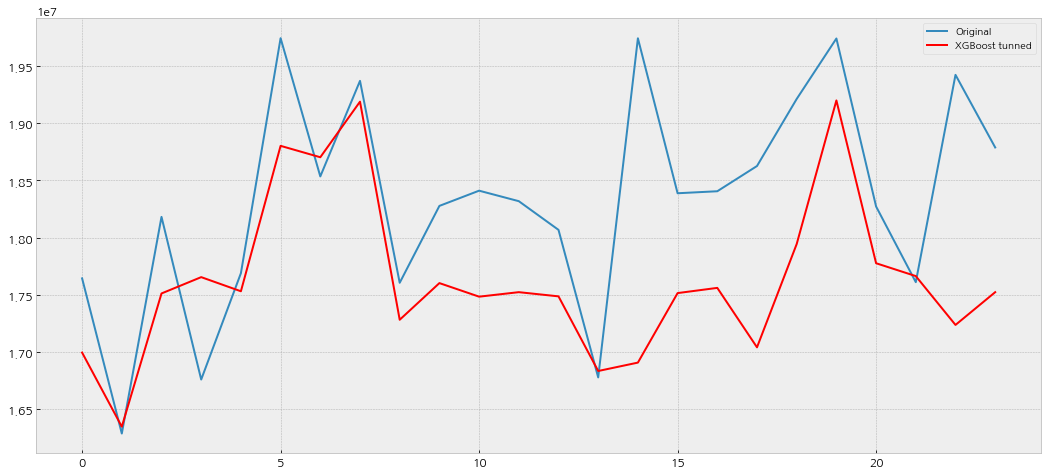

In [68]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='XGBoost tunned')
plt.legend()

In [69]:
resultsDict

{'ARIMA': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoARIMA (1, 1, 0)': {'mae': 904109.8437019134,
  'rmse': 1132129.621624738,
  'mape': 0.04934309757574341,
  'r2': -0.4995091062525412},
 'SARIMAX': {'mae': 1055987.297015898,
  'rmse': 1271940.9901568769,
  'mape': 0.057657087780115,
  'r2': -0.8927389824014909},
 'AutoSARIMAX (1, 1, 0),(2, 0, 2, 6)': {'mae': 876188.6301761378,
  'rmse': 1079316.809357483,
  'mape': 0.04754833557566234,
  'r2': -0.36287078485958},
 'Prophet univariate': {'mae': 652083.3123067898,
  'rmse': 883848.009299854,
  'mape': 0.03558679976877615,
  'r2': 0.08607201393111785},
 'Randomforest': {'mae': 760071.7591666671,
  'rmse': 942424.9559724096,
  'mape': 0.04088445211782288,
  'r2': -0.03908327890409269},
 'XGBoost': {'mae': 745320.4583333334,
  'rmse': 985533.2063473517,
  'mape': 0.039760744961155,
  'r2': -0.13631652887291779},
 'Lightgbm': {'mae': 688704.5463087913,
  'rmse':

## Feature importance (lightGBM example)

Some models allow for for native feature importance algorithms but I personally like the library [SHAP](https://github.com/slundberg/shap) that provides a game theory approach to measure how each feature affects our forecast.

Here is an example on how to use SHAP for our Lightgbm model

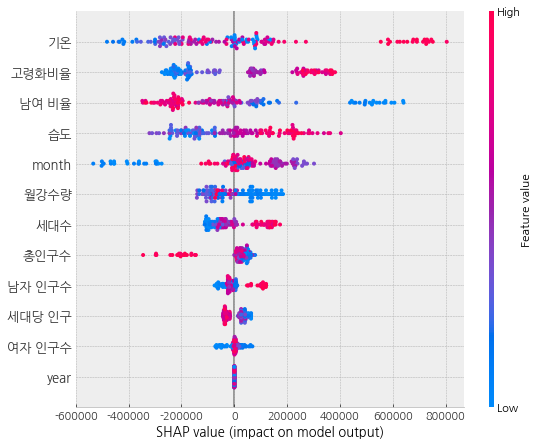

In [70]:
explainer = shap.TreeExplainer(lightGBM)
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_train_df)

In [71]:
df = pd.DataFrame.from_dict(resultsDict).transpose().iloc[::-1]
df = df.round(2)
df.to_csv("results/results_summary.csv")

In [72]:
df.to_html("results/results_summary.html")